## Dog Breed Classification - Resnet 50 From Scratch

In [1]:
# Importing the required Libraries

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from keras.models import Model
from keras.optimizers import Adam
from keras.initializers import glorot_uniform
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras.layers import Input, Add, Activation, BatchNormalization, Conv2D, ZeroPadding2D
from keras.layers import Dense, Flatten, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D

%matplotlib inline
sns.set_theme(style="darkgrid")

#### 1. Data Preprocessing

In [3]:
df = pd.read_csv("./data/labels.csv")

In [4]:
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [5]:
len(df["breed"].unique())

120

In [6]:
# Required Dog Breed List
breedList = ["beagle", "chihuahua", "doberman", "french_bulldog", "golden_retriever",
             "malamute", "pug", "saint_bernard", "scottish_deerhound", "tibetan_mastiff"]

In [7]:
# The dataset consists of 120 Canine Classes
# from which the non required classes are filtered out

df = df[df["breed"].isin(breedList)]

In [8]:
df.head()

,id,breed
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
20,008b1271ed1addaccf93783b39deab45,doberman
25,00a366d4b4a9bbb6c8a63126697b7656,golden_retriever
37,0100f55e4f0fe28f2c0465d3fc4b9897,golden_retriever


#### 2. Data Visualization

In [9]:
df["breed"].describe()

count                    841
unique                    10
top       scottish_deerhound
freq                     126
Name: breed, dtype: object

In [10]:
df["breed"].value_counts()

scottish_deerhound    126
beagle                105
pug                    94
saint_bernard          84
malamute               81
doberman               74
chihuahua              71
french_bulldog         70
tibetan_mastiff        69
golden_retriever       67
Name: breed, dtype: int64

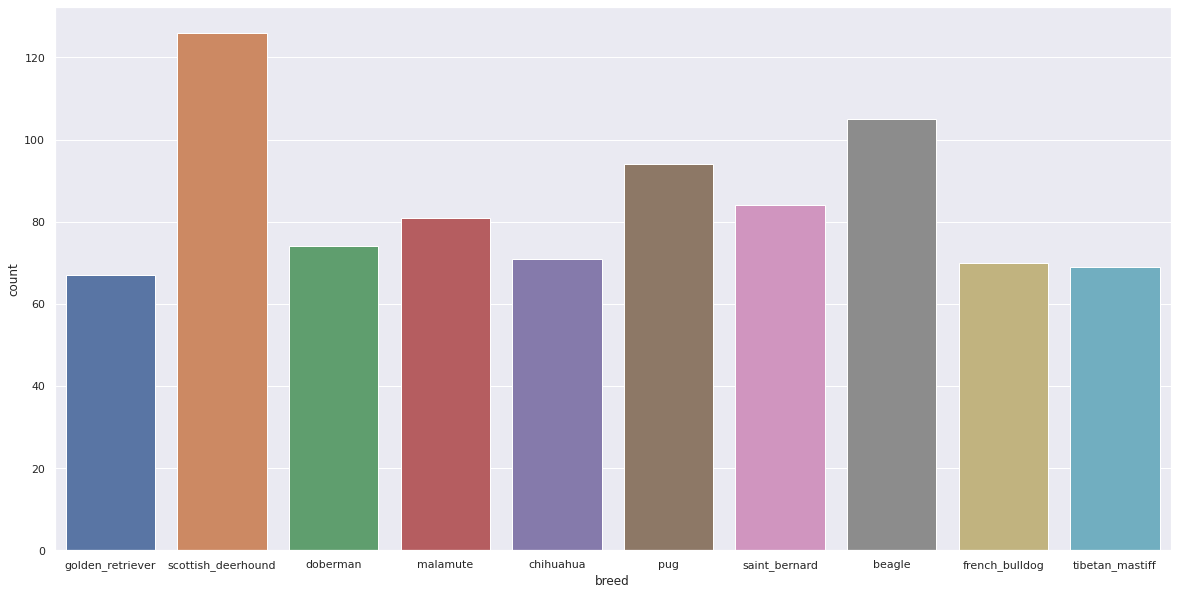

In [11]:
# Category Count Plot to check for imbalances in the dataset

plt.subplots(figsize=(20, 10))
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)

ax = sns.countplot(x = "breed", data = df)

10% of the images from training set is randomly taken as validation data & 5 Images were taken from each category for testing data

In [13]:
train_dir = os.path.join(os.getcwd(), "data", "train")
val_dir = os.path.join(os.getcwd(), "data", "val")
test_dir = os.path.join(os.getcwd(), "data", "test")

#### 3. Model Training

In [14]:
def identity_block(X, conv_size, filters, stage, block):
    
    conv_base_name = f"res{stage}{block}_branch"
    bn_base_name = f"bn{stage}{block}_branch"
    
    f1, f2, f3 = filters
    
    # Identity Input
    X_shortcut = X
    
    # Main Path
    
    # First Component of the main path
    X = Conv2D(filters = f1, kernel_size = (1, 1), strides = (1, 1), 
               padding = "valid", name=f"{conv_base_name}_2a",
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = f"{bn_base_name}_2a")(X)
    X = Activation("relu")(X)
    
    # Second Component of the main path
    X = Conv2D(filters = f2, kernel_size = (conv_size, conv_size), strides = (1, 1),
               padding='same', name=f"{conv_base_name}_2b",
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = f"{bn_base_name}_2b")(X)
    X = Activation("relu")(X)
    
    # Third Component of the main path
    X = Conv2D(filters = f3, kernel_size = (1, 1), strides = (1, 1), 
               padding = "valid", name=f"{conv_base_name}_2c",
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = f"{bn_base_name}_2c")(X)
    
    # Adding shortcut to the main path
    X = Add()([X, X_shortcut])
    X = Activation("relu")(X)
    
    return X

In [15]:
def convolutional_block(X, conv_size, filters, stage, block, stride_size = 2):
    
    conv_base_name = f"res{stage}{block}_branch"
    bn_base_name = f"bn{stage}{block}_branch"
    
    f1, f2, f3 = filters
    
    # Identity Input
    X_shortcut = X
    
    # Main Path
    
    # First Component of the main path
    X = Conv2D(filters = f1, kernel_size = (1, 1), strides = (stride_size, stride_size),
               name=f"{conv_base_name}_2a", kernel_initializer=glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name=f"{bn_base_name}_2a")(X)
    X = Activation("relu")(X)
    
    # Second Component of the main path
    X = Conv2D(filters = f2, kernel_size = (conv_size, conv_size), strides = (1, 1), padding = "same",
               name=f"{conv_base_name}_2b", kernel_initializer=glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name=f"{bn_base_name}_2b")(X)
    X = Activation("relu")(X)
    
    # Third Component of the main path
    X = Conv2D(filters = f3, kernel_size = (1, 1), strides = (1, 1), padding = "valid",
               name=f"{conv_base_name}_2c", kernel_initializer=glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name=f"{bn_base_name}_2c")(X)
    
    # Shortcut Path
    X_shortcut = Conv2D(filters = f3, kernel_size = (1, 1), strides = (stride_size, stride_size), padding = "valid",
                        name=f"{conv_base_name}_1", kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = f"{bn_base_name}_1")(X_shortcut)
    
    # Adding the main path and shortcut
    X = Add()([X, X_shortcut])
    X = Activation("relu")(X)
    
    return X

In [16]:
def ResNet50(input_shape, classes):
    
    # Input Tensor with shape input_shape
    X_input = Input(input_shape)
    
    # Zero - Padding
    X = ZeroPadding2D(padding=(3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2), name="conv1",
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name="bn_conv1")(X)
    X = Activation("relu")(X)
    X = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(X)
    
    # Stage 2
    X = convolutional_block(X, conv_size=3, filters=(64, 64, 256),
                            stage=2, block="a", stride_size=2)
    X = identity_block(X, conv_size=3, filters=(64, 64, 256), stage=2, block="b")
    X = identity_block(X, conv_size=3, filters=(64, 64, 256), stage=2, block="c")
    
    # Stage 3
    X = convolutional_block(X, conv_size=3, filters=(128, 128, 512), stage=3, block="a", stride_size=2)
    X = identity_block(X, conv_size=3, filters=(128, 128, 512), stage=3, block="b")
    X = identity_block(X, conv_size=3, filters=(128, 128, 512), stage=3, block="c")
    X = identity_block(X, conv_size=3, filters=(128, 128, 512), stage=3, block="d")
    
    # Stage 4
    X = convolutional_block(X, conv_size=3, filters=(256, 256, 1024), stage=4, block="a", stride_size=2)
    X = identity_block(X, conv_size=3, filters=(256, 256, 1024), stage=4, block="b")
    X = identity_block(X, conv_size=3, filters=(256, 256, 1024), stage=4, block="c")
    X = identity_block(X, conv_size=3, filters=(256, 256, 1024), stage=4, block="d")
    X = identity_block(X, conv_size=3, filters=(256, 256, 1024), stage=4, block="e")
    X = identity_block(X, conv_size=3, filters=(256, 256, 1024), stage=4, block="f")
    
    # Stage 5
    X = convolutional_block(X, conv_size=3, filters=(512, 512, 2048), stage=5, block="a", stride_size=2)
    X = identity_block(X, conv_size=3, filters=(512, 512, 2048), stage=5, block="b")
    X = identity_block(X, conv_size=3, filters=(512, 512, 2048), stage=5, block="c")
    
    # Average Pooling
    X = AveragePooling2D(pool_size=(2, 2), name="avg_pool")(X)
    
    # Flatten the Output from Average Pooling
    X = Flatten()(X)
    X = Dense(units=classes, activation="softmax", name=f"fc_{classes}",
              kernel_initializer=glorot_uniform(seed=0))(X)
    
    # Creating the model
    model = Model(inputs=X_input, outputs=X, name="ResNet50")
    
    return model

In [25]:
model = ResNet50(input_shape=(224, 224, 3), classes=10)

In [26]:
opt = Adam(learning_rate=0.001)

tensorboard_callback = TensorBoard(log_dir="./logs")
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [27]:
model.compile(optimizer=opt, loss="categorical_crossentropy",
              metrics=["accuracy"])

In [28]:
# Printing the model summary
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [29]:
# Image Data Generator for Training and Testing
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
BATCH_SIZE=8

train_datagen = ImageDataGenerator(rescale=1.0/255, rotation_range=15,
                                   width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(directory=train_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                                    batch_size=BATCH_SIZE, seed=0)
val_generator = val_datagen.flow_from_directory(directory=val_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                                    batch_size=BATCH_SIZE, seed=0)

Found 707 images belonging to 10 classes.
Found 84 images belonging to 10 classes.


In [30]:
# Config
EPOCHS=50
STEPS_PER_EPOCH=train_generator.n // BATCH_SIZE
VALIDATION_STEPS=val_generator.n // BATCH_SIZE

In [31]:
history = model.fit(train_generator, steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS,
                    validation_data=val_generator, validation_steps=VALIDATION_STEPS,
                    callbacks=[reduce_lr, early_stopping, tensorboard_callback])

Epoch 1/50
88/88 [==============================] - 173s 2s/step - loss: 10.0904 - accuracy: 0.1006 - val_loss: 2.4735 - val_accuracy: 0.1125
Epoch 2/50
88/88 [==============================] - 12s 134ms/step - loss: 4.1670 - accuracy: 0.0826 - val_loss: 2.5099 - val_accuracy: 0.1500
Epoch 3/50
88/88 [==============================] - 12s 135ms/step - loss: 3.4378 - accuracy: 0.1042 - val_loss: 11.2030 - val_accuracy: 0.1750
Epoch 4/50
88/88 [==============================] - 12s 134ms/step - loss: 2.5226 - accuracy: 0.1116 - val_loss: 2.4260 - val_accuracy: 0.1250
Epoch 5/50
88/88 [==============================] - 12s 133ms/step - loss: 2.2816 - accuracy: 0.1744 - val_loss: 2.2633 - val_accuracy: 0.1750
Epoch 6/50
88/88 [==============================] - 12s 133ms/step - loss: 2.2595 - accuracy: 0.2018 - val_loss: 2.1699 - val_accuracy: 0.1625
Epoch 7/50
88/88 [==============================] - 12s 133ms/step - loss: 2.2403 - accuracy: 0.1881 - val_loss: 2.2206 - val_accuracy: 0.1500

I tried implementing ResNet 50 from scratch but as there are 23,616,522 parameters to learn and the dataset is quite small
and the model is not converging the training was stopped and instead Transfer Learning is used.